In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/widsdatathon2025/SAMPLE_SUBMISSION.xlsx
/kaggle/input/widsdatathon2025/Data Dictionary.xlsx
/kaggle/input/widsdatathon2025/TRAIN_OLD/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv
/kaggle/input/widsdatathon2025/TRAIN_OLD/TRAINING_SOLUTIONS.xlsx
/kaggle/input/widsdatathon2025/TRAIN_OLD/TRAIN_CATEGORICAL_METADATA.xlsx
/kaggle/input/widsdatathon2025/TRAIN_OLD/TRAIN_QUANTITATIVE_METADATA.xlsx
/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx
/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv
/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx
/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx
/kaggle/input/widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv
/kaggle/input/widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx
/kaggle/input/widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
import xgboost as xgb
import xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## EDA

### Data Dictionary

In [3]:
dict = pd.read_excel("/kaggle/input/widsdatathon2025/Data Dictionary.xlsx")

In [4]:
dict

,DataType,Instrument,Field,Description,Type,Labels
0,QUANTITATIVE METADATA,NaN,NaN,NaN,NaN,NaN
1,NaN,Identifier,participant_id,Participant ID,str,NaN
2,Quantitative,Edinburgh Handedness Questionnaire,EHQ_EHQ_Total,Laterality Index (Score),float,-100 = 10th left\n−28 ≤ LI < 48 = middle\n100 ...
3,Quantitative,Ishihara Color Vision Test,ColorVision_CV_Score,Color vision test score,int,NaN
4,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_CP,Corporal Punishment Score,int,NaN
5,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_ID,Inconsistent Discipline Score,int,NaN
6,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_INV,Involvement Score,int,NaN
7,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_OPD,Other Discipline Practices Score (Not factored...,int,NaN
8,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_PM,Poor Monitoring/Supervision Score,int,NaN
9,Quantitative,Alabama Parenting Questionnaire - Parent Report,APQ_P_APQ_P_PP,Positive Parenting Score,int,NaN


### Categorical Features

In [5]:
train_cat = pd.read_excel("/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx")
test_cat = pd.read_excel("/kaggle/input/widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx")

In [6]:
train_cat.columns

Index(['participant_id', 'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ'],
      dtype='object')

In [7]:
print(train_cat.shape)
print(test_cat.shape)

(1213, 10)
(304, 10)


In [8]:
train_cat.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
0,00aIpNTbG5uh,2019,4,1.0,0.0,3.0,21.0,45.0,NaN,NaN
1,00fV0OyyoLfw,2017,1,0.0,9.0,2.0,21.0,0.0,21.0,45.0
2,04X1eiS79T4B,2017,1,1.0,2.0,2.0,9.0,0.0,NaN,NaN
3,05ocQutkURd6,2018,1,3.0,8.0,2.0,18.0,10.0,18.0,0.0
4,06YUNBA9ZRLq,2018,1,0.0,1.0,2.0,12.0,0.0,NaN,NaN


In [9]:
cat_columns = train_cat.columns.drop("participant_id")
cat_columns

Index(['Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ'],
      dtype='object')

In [10]:
train_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   participant_id                    1213 non-null   object 
 1   Basic_Demos_Enroll_Year           1213 non-null   int64  
 2   Basic_Demos_Study_Site            1213 non-null   int64  
 3   PreInt_Demos_Fam_Child_Ethnicity  1170 non-null   float64
 4   PreInt_Demos_Fam_Child_Race       1159 non-null   float64
 5   MRI_Track_Scan_Location           1210 non-null   float64
 6   Barratt_Barratt_P1_Edu            1198 non-null   float64
 7   Barratt_Barratt_P1_Occ            1182 non-null   float64
 8   Barratt_Barratt_P2_Edu            1015 non-null   float64
 9   Barratt_Barratt_P2_Occ            991 non-null    float64
dtypes: float64(7), int64(2), object(1)
memory usage: 94.9+ KB


In [11]:
train_cat.isna().sum()

participant_id                        0
Basic_Demos_Enroll_Year               0
Basic_Demos_Study_Site                0
PreInt_Demos_Fam_Child_Ethnicity     43
PreInt_Demos_Fam_Child_Race          54
MRI_Track_Scan_Location               3
Barratt_Barratt_P1_Edu               15
Barratt_Barratt_P1_Occ               31
Barratt_Barratt_P2_Edu              198
Barratt_Barratt_P2_Occ              222
dtype: int64

In [12]:
test_cat.isna().sum()

participant_id                       0
Basic_Demos_Enroll_Year              0
Basic_Demos_Study_Site               0
PreInt_Demos_Fam_Child_Ethnicity     3
PreInt_Demos_Fam_Child_Race          6
MRI_Track_Scan_Location              0
Barratt_Barratt_P1_Edu               1
Barratt_Barratt_P1_Occ               1
Barratt_Barratt_P2_Edu              36
Barratt_Barratt_P2_Occ              42
dtype: int64

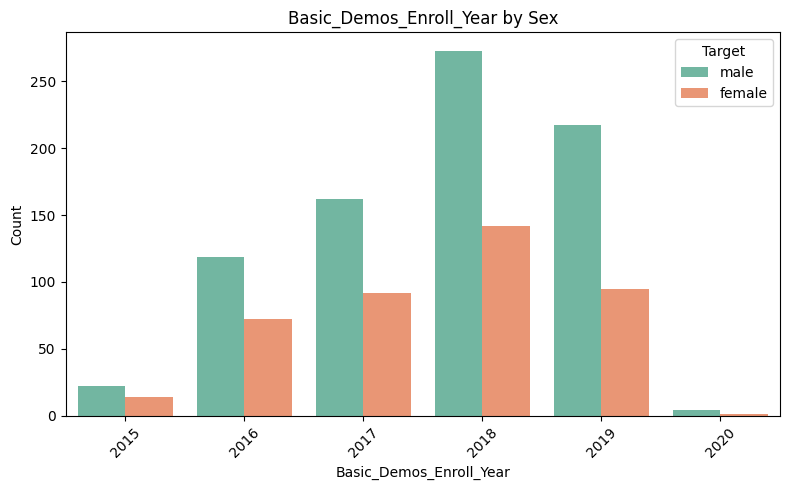

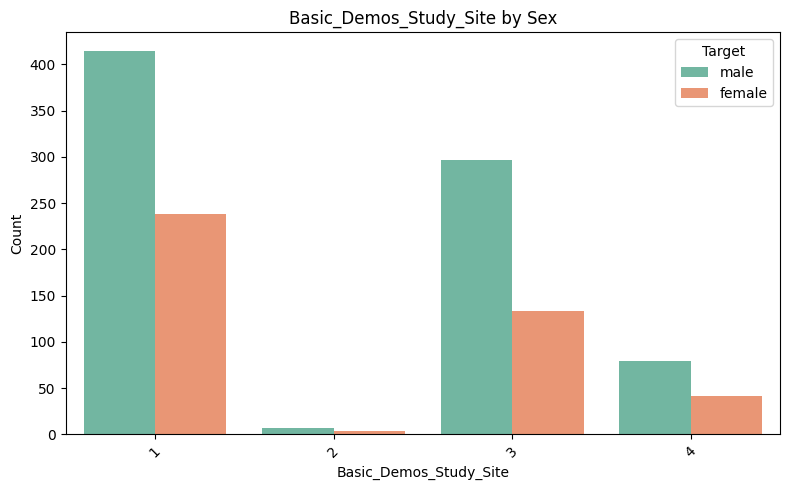

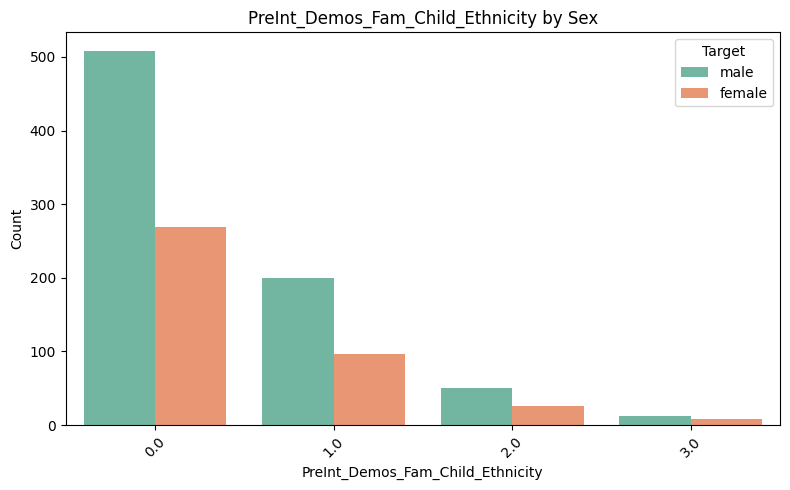

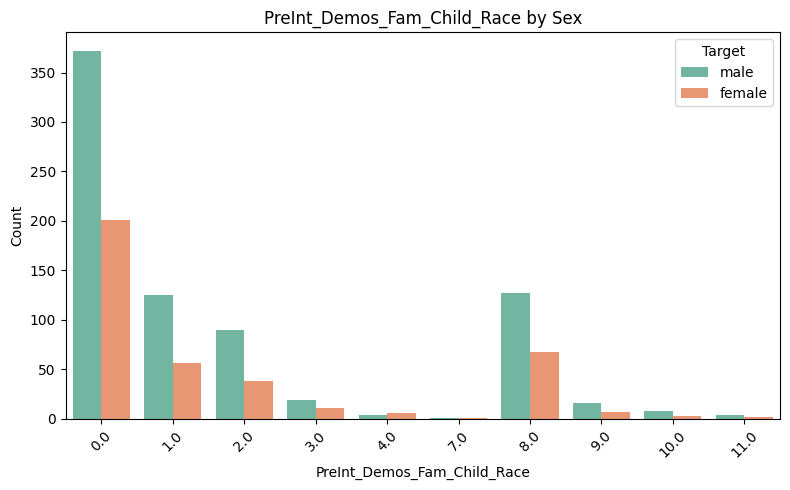

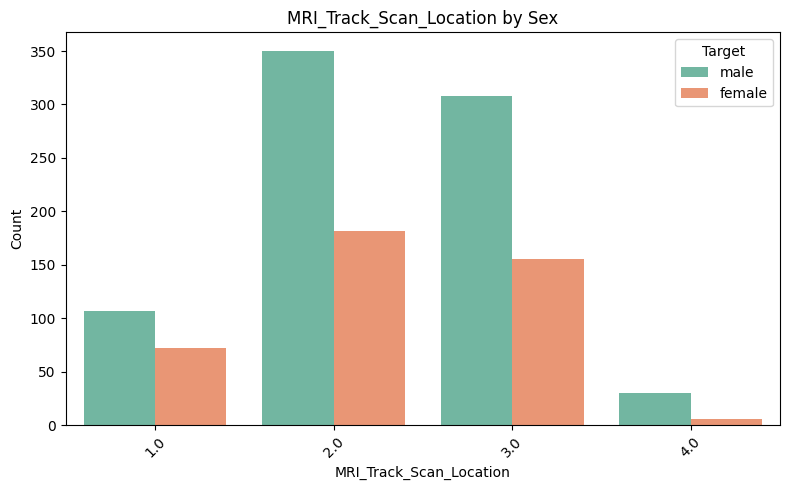

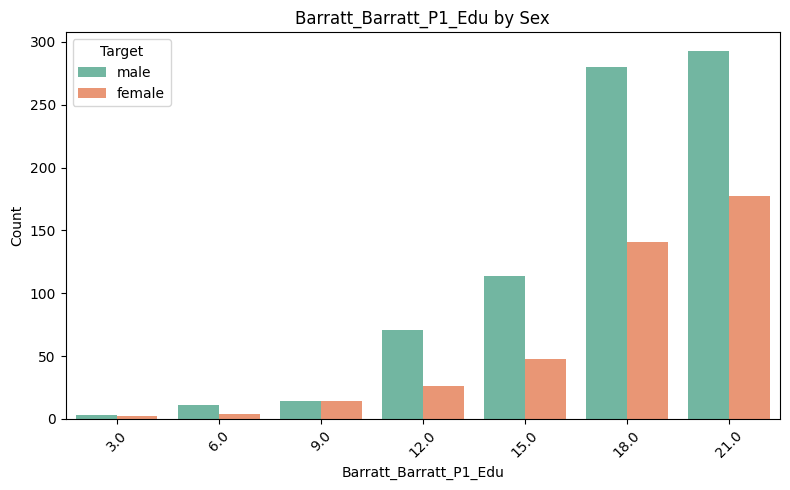

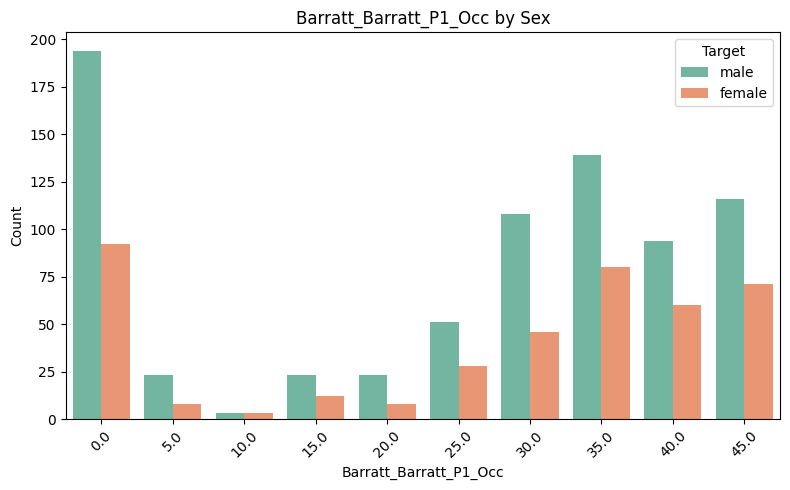

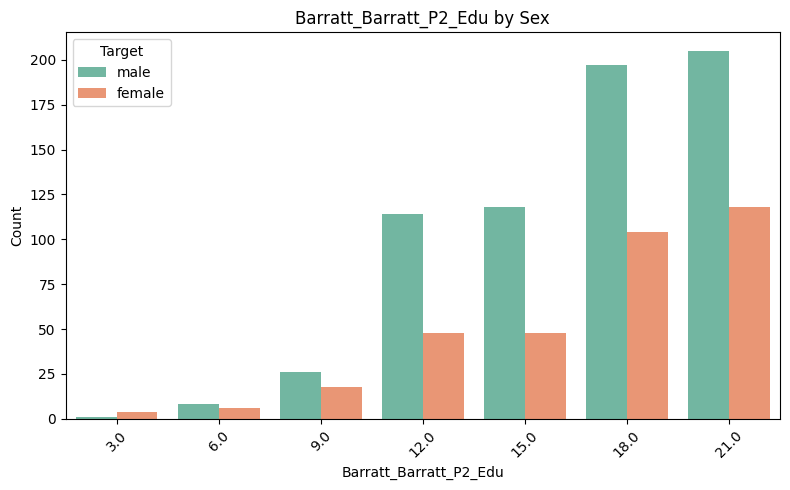

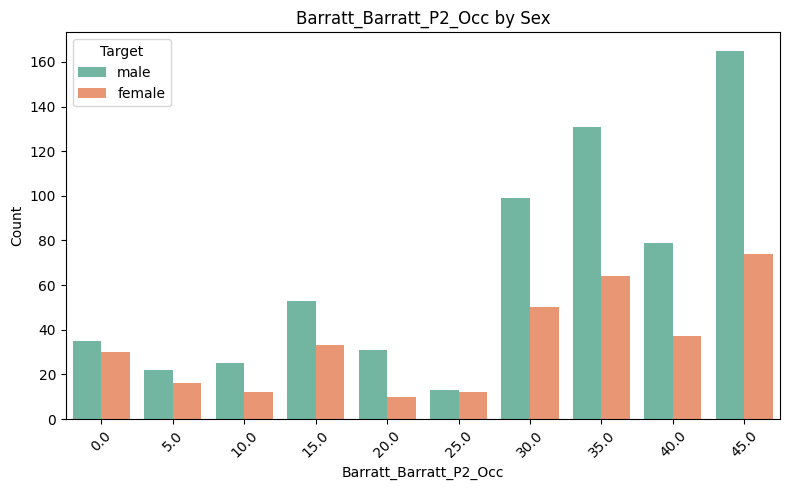

In [13]:
y_train = pd.read_excel("/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")
y_train['Sex_F'] = y_train['Sex_F'].map({0: 'male', 1: 'female'})
cat_full = pd.merge(train_cat, y_train, on="participant_id")

for col in cat_columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=cat_full, x=col, hue='Sex_F', palette='Set2')
    plt.title(f'{col} by Sex')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Target')
    plt.tight_layout()
    plt.show()

### Quantitative Features

In [14]:
train_quant = pd.read_excel("/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
test_quant = pd.read_excel("/kaggle/input/widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx")

In [15]:
print(train_quant.shape)
print(test_quant.shape)

(1213, 19)
(304, 19)


In [16]:
train_quant.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,00aIpNTbG5uh,100.00,13.0,3.0,15.0,44.0,14.0,20.0,27.0,3.0,17.0,4.0,11.0,5.0,8.0,6.0,2.0,9.0,14.274127
1,00fV0OyyoLfw,92.27,14.0,3.0,12.0,35.0,25.0,28.0,30.0,5.0,20.0,4.0,13.0,5.0,8.0,7.0,3.0,8.0,NaN
2,04X1eiS79T4B,86.67,14.0,3.0,21.0,37.0,18.0,26.0,28.0,3.0,24.0,7.0,10.0,10.0,7.0,14.0,7.0,7.0,13.463381
3,05ocQutkURd6,93.34,14.0,3.0,11.0,42.0,15.0,20.0,28.0,0.0,5.0,0.0,3.0,0.0,3.0,2.0,2.0,6.0,9.572553
4,06YUNBA9ZRLq,0.00,14.0,8.0,12.0,35.0,22.0,12.0,24.0,6.0,23.0,7.0,15.0,8.0,9.0,8.0,1.0,4.0,6.654574


In [17]:
test_quant.isna().sum()

participant_id                 0
EHQ_EHQ_Total                  1
ColorVision_CV_Score           9
APQ_P_APQ_P_CP                15
APQ_P_APQ_P_ID                15
APQ_P_APQ_P_INV               15
APQ_P_APQ_P_OPD               15
APQ_P_APQ_P_PM                15
APQ_P_APQ_P_PP                15
SDQ_SDQ_Conduct_Problems      30
SDQ_SDQ_Difficulties_Total    30
SDQ_SDQ_Emotional_Problems    30
SDQ_SDQ_Externalizing         30
SDQ_SDQ_Generating_Impact     30
SDQ_SDQ_Hyperactivity         30
SDQ_SDQ_Internalizing         30
SDQ_SDQ_Peer_Problems         30
SDQ_SDQ_Prosocial             30
MRI_Track_Age_at_Scan          0
dtype: int64

In [18]:
quant_columns = train_quant.columns.drop("participant_id")
quant_full = pd.merge(train_quant, y_train, on="participant_id")
train_quant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   participant_id              1213 non-null   object 
 1   EHQ_EHQ_Total               1200 non-null   float64
 2   ColorVision_CV_Score        1190 non-null   float64
 3   APQ_P_APQ_P_CP              1201 non-null   float64
 4   APQ_P_APQ_P_ID              1201 non-null   float64
 5   APQ_P_APQ_P_INV             1201 non-null   float64
 6   APQ_P_APQ_P_OPD             1201 non-null   float64
 7   APQ_P_APQ_P_PM              1201 non-null   float64
 8   APQ_P_APQ_P_PP              1201 non-null   float64
 9   SDQ_SDQ_Conduct_Problems    1204 non-null   float64
 10  SDQ_SDQ_Difficulties_Total  1204 non-null   float64
 11  SDQ_SDQ_Emotional_Problems  1204 non-null   float64
 12  SDQ_SDQ_Externalizing       1204 non-null   float64
 13  SDQ_SDQ_Generating_Impact   1204 

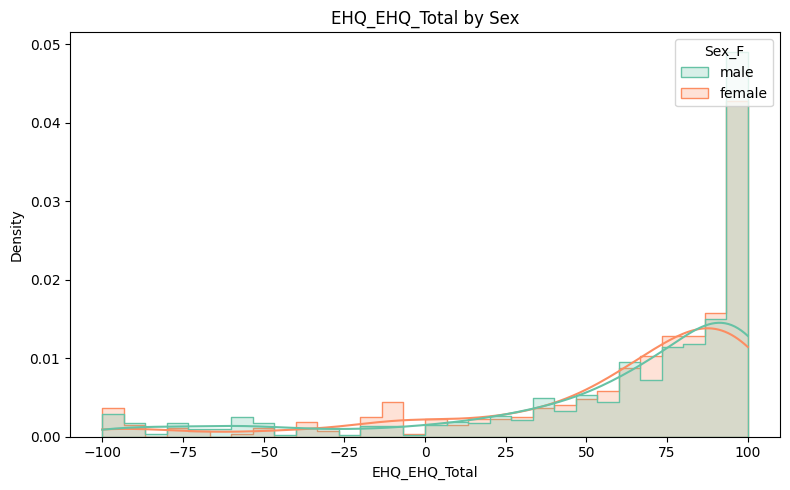

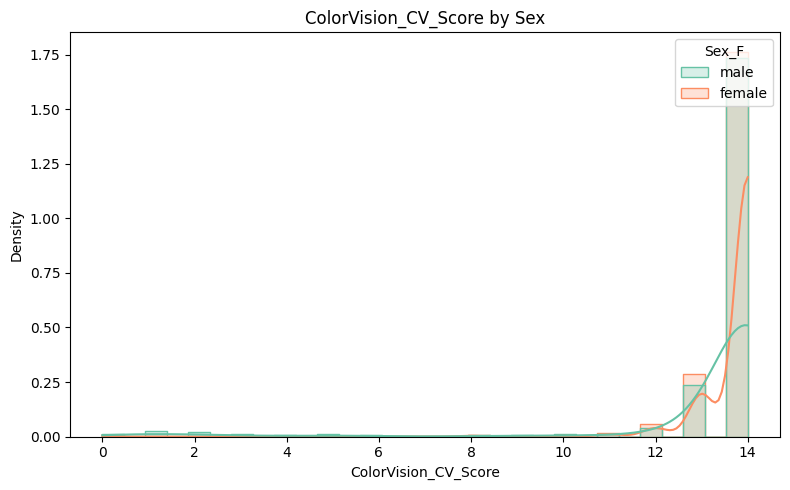

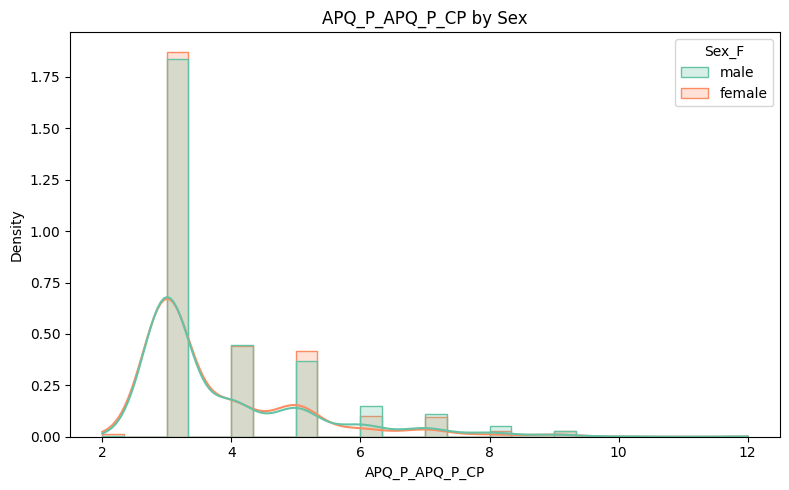

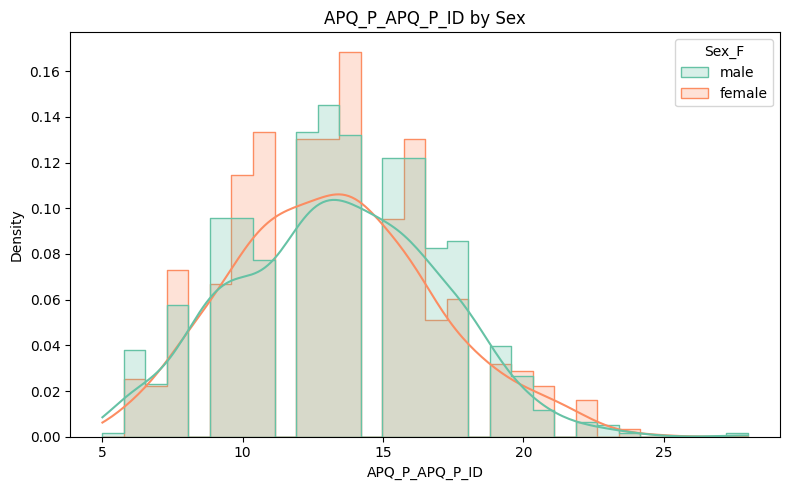

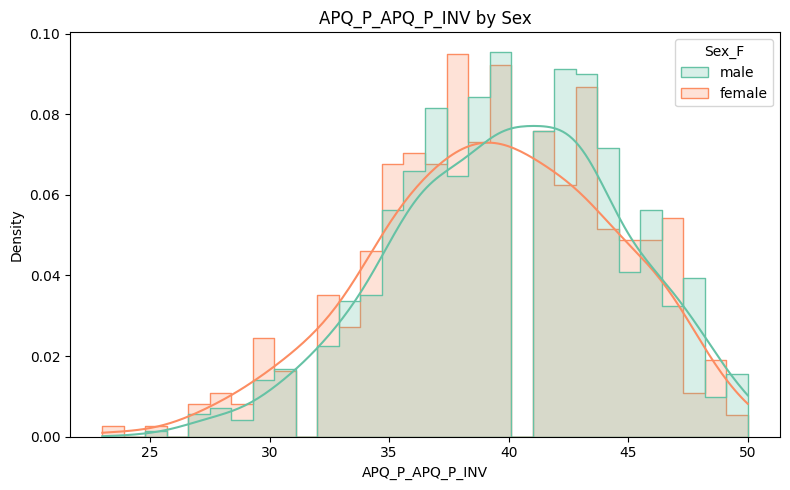

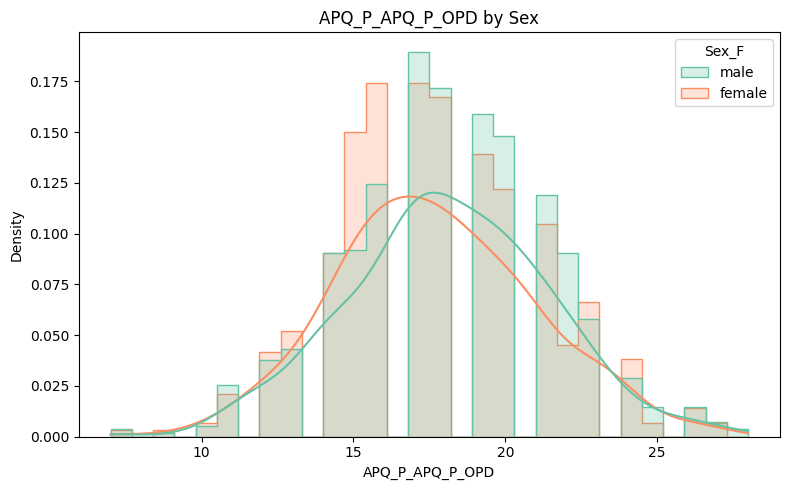

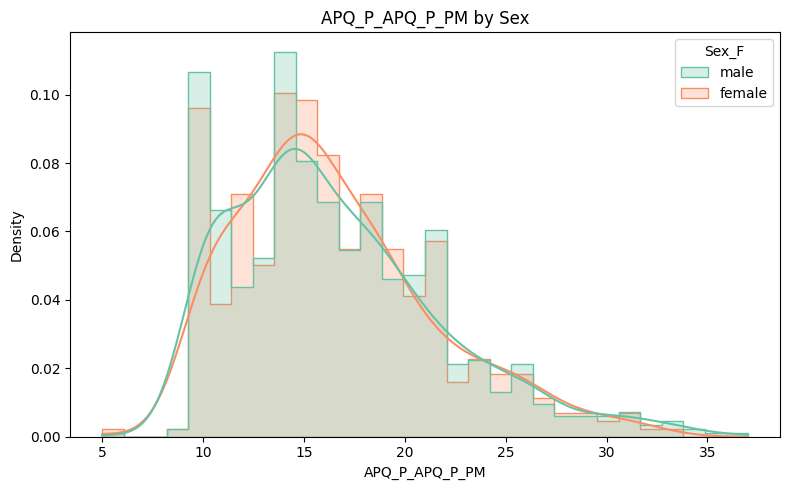

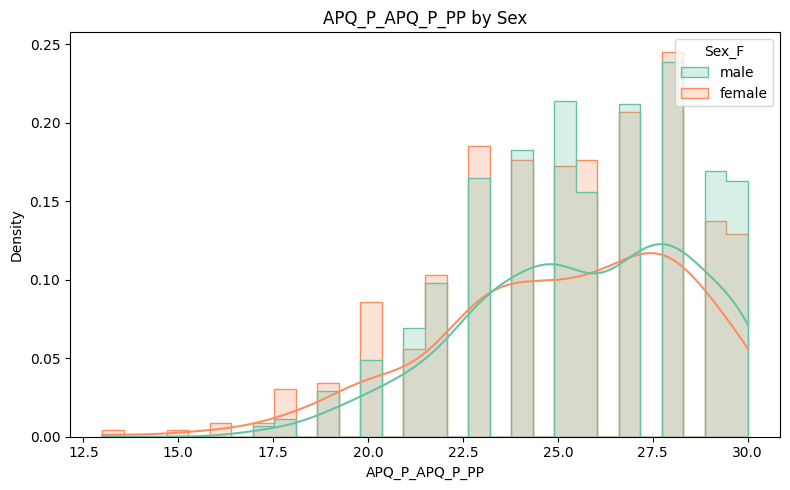

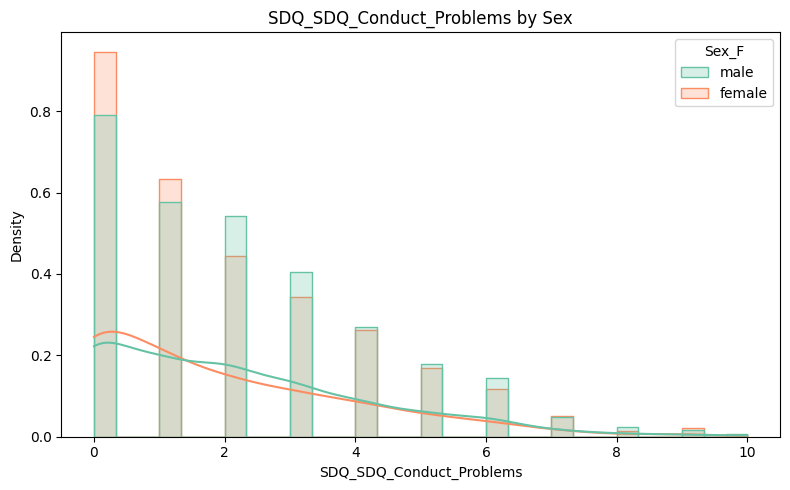

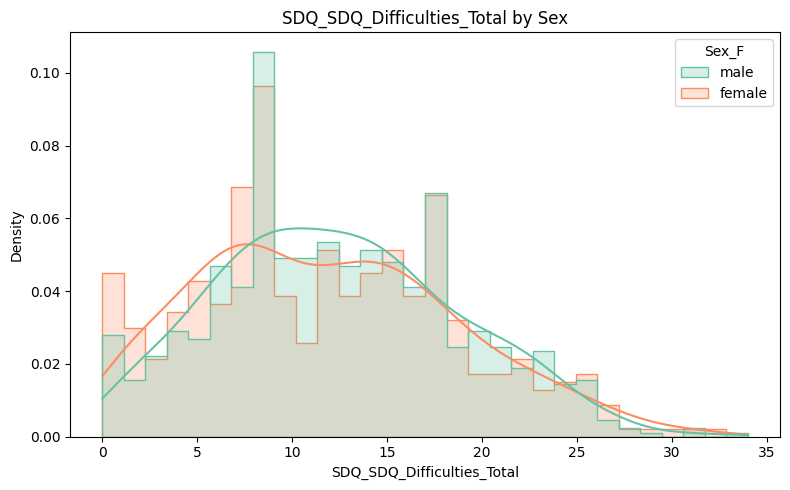

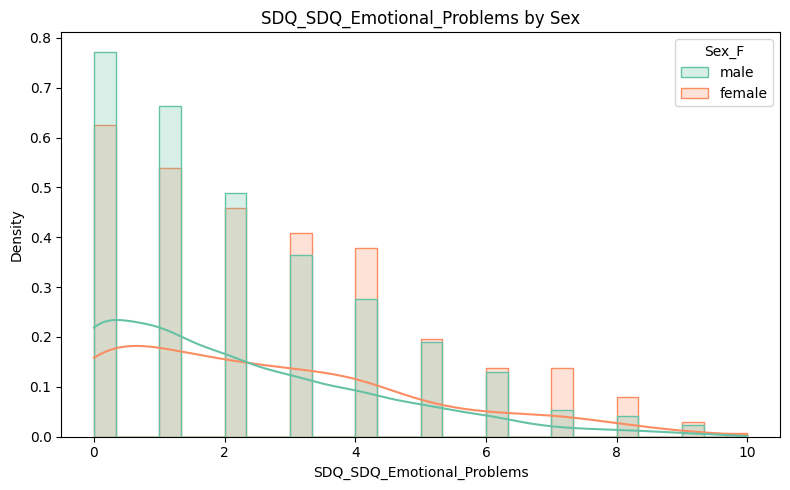

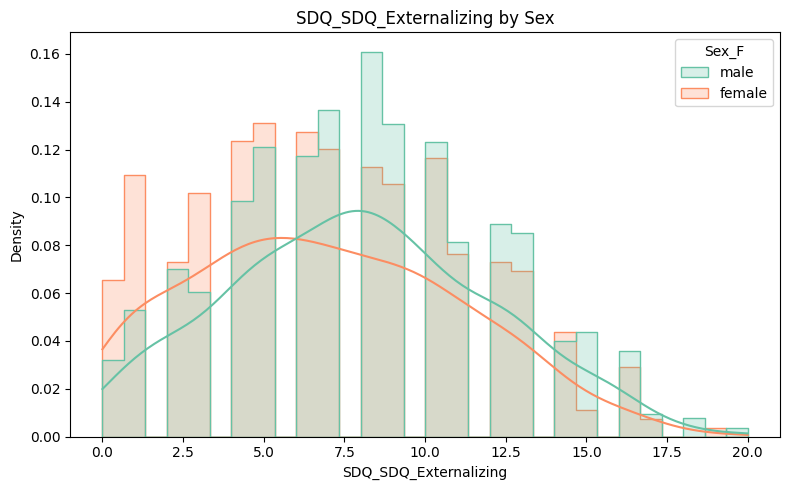

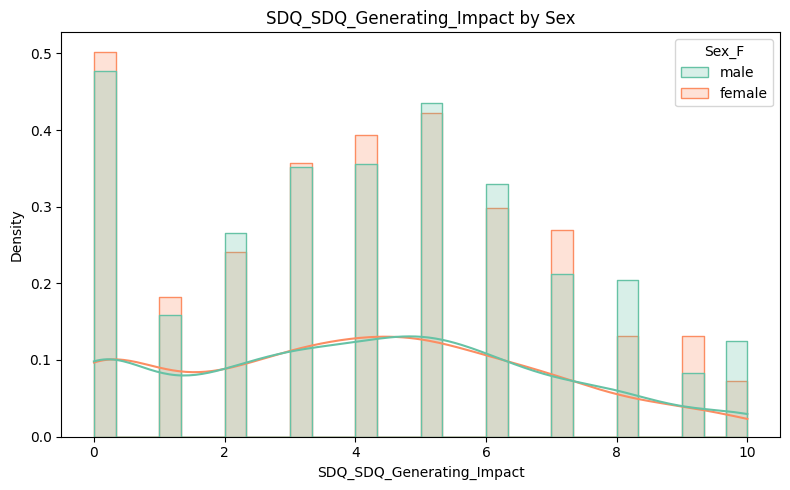

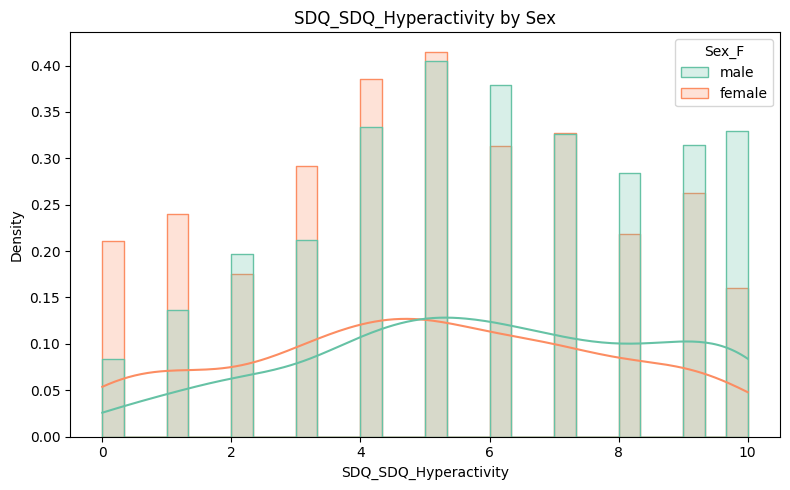

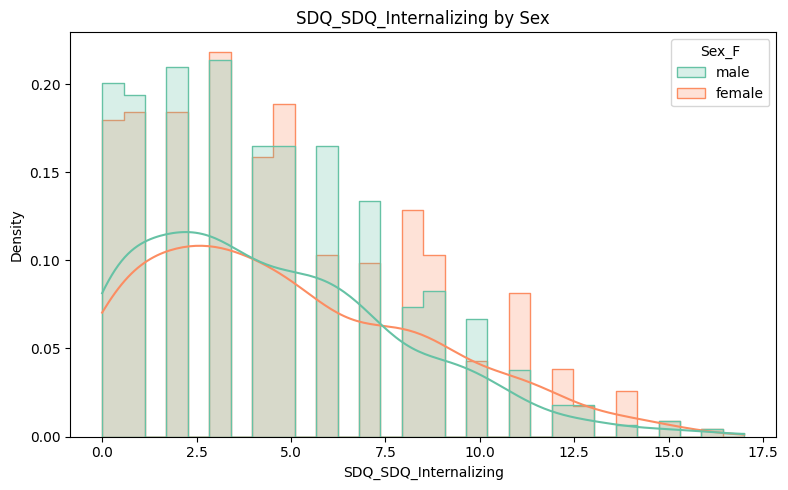

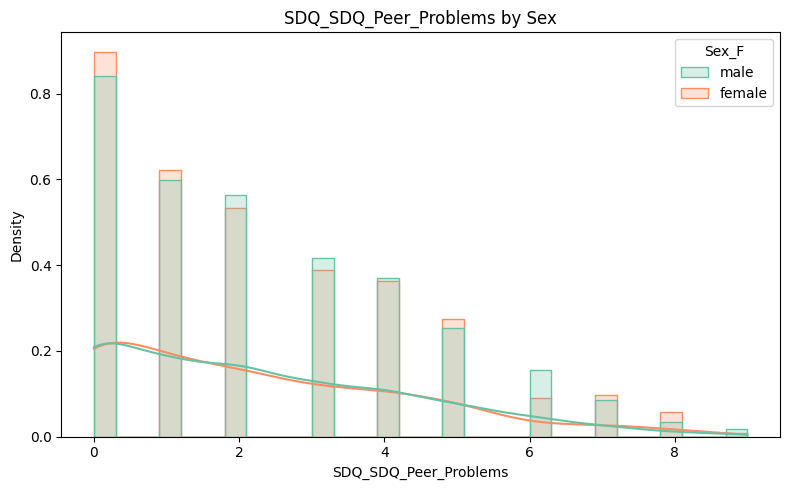

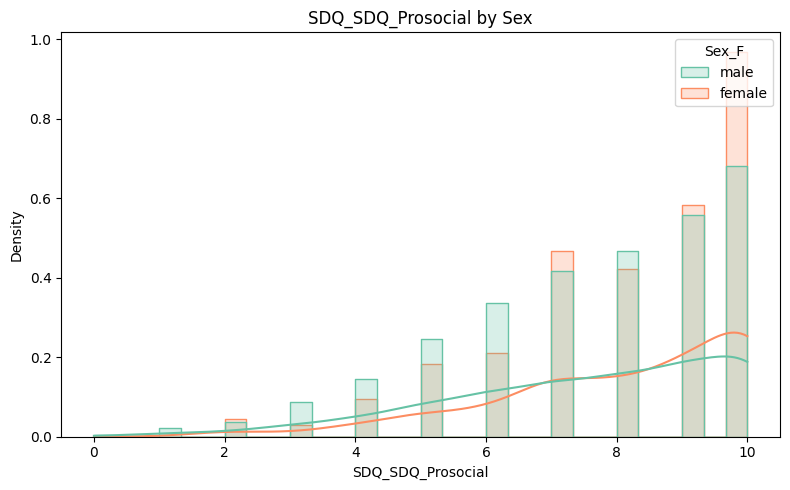

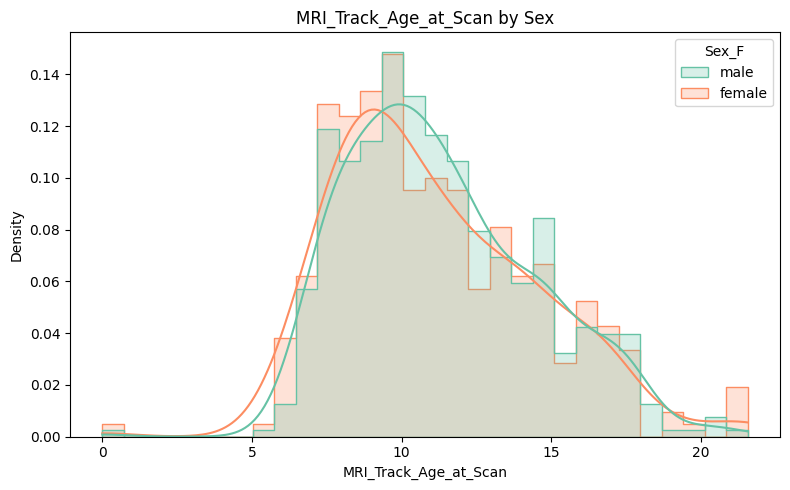

In [19]:
quant_columns = train_quant.columns.drop("participant_id")
quant_full = pd.merge(train_quant, y_train, on="participant_id")

for col in quant_columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=quant_full, x=col, hue='Sex_F', kde=True, bins=30, palette='Set2', element='step', stat='density', common_norm=False)
    plt.title(f'{col} by Sex')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()

In [20]:
# Selected quant features by EDA results
quant_sex = ["APQ_P_APQ_P_ID", "APQ_P_APQ_P_INV", "SDQ_SDQ_Difficulties_Total", \
             "SDQ_SDQ_Emotional_Problems", "SDQ_SDQ_Externalizing", "SDQ_SDQ_Hyperactivity", \
            "SDQ_SDQ_Prosocial", "MRI_Track_Age_at_Scan"]

### Targets

0= Other/None, 1=ADHD

0=Male   
1=Female


In [21]:
targets = pd.read_excel("/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")

In [22]:
targets.head()

,participant_id,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,1,1
1,CPaeQkhcjg7d,1,0
2,Nb4EetVPm3gs,1,0
3,p4vPhVu91o4b,1,1
4,M09PXs7arQ5E,1,1


Text(0, 0.5, 'Count')

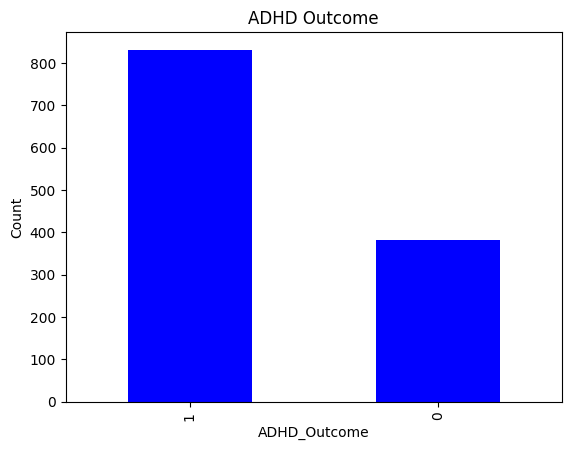

In [23]:
targets['ADHD_Outcome'].value_counts().plot(kind='bar', color='blue')
plt.title('ADHD Outcome')
plt.ylabel("Count")

Text(0, 0.5, 'Count')

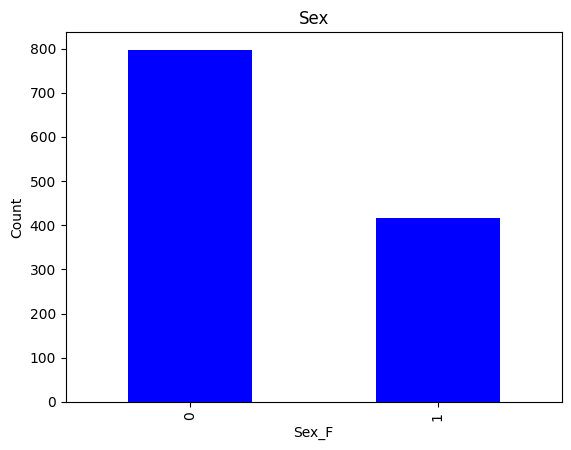

In [24]:
targets['Sex_F'].value_counts().plot(kind='bar', color='blue')
plt.title('Sex')
plt.ylabel("Count")

In [25]:
targets['ADHD_Outcome'].value_counts(normalize=True)

ADHD_Outcome
1    0.685078
0    0.314922
Name: proportion, dtype: float64

In [26]:
targets['Sex_F'].value_counts(normalize=True)

Sex_F
0    0.657049
1    0.342951
Name: proportion, dtype: float64

## Preprocessing

### Categorical variables

In [27]:
# these are features that are not useful for neither adhd nor sex
drop_features = ['Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site', 'MRI_Track_Scan_Location']
train_cat = train_cat.drop(columns=drop_features, axis=1)
test_cat = test_cat.drop(columns=drop_features, axis=1)
cat_columns = [col for col in cat_columns if col not in drop_features]

#### Impute missing values

In [28]:
imputer = SimpleImputer(strategy="most_frequent")
imputer.fit(train_cat) 

cat_columns = train_cat.columns

train_cat_imputed = pd.DataFrame(imputer.transform(train_cat), columns=cat_columns)
test_cat_imputed = pd.DataFrame(imputer.transform(test_cat), columns=cat_columns)

for name, df in {"train": train_cat_imputed, "test": test_cat_imputed}.items():
    if df.isna().sum().sum() == 0:
        print(f"Missing values imputed for {name} categorical features")
    else:
        print(f"Some missing values still remain in {name} categorical features")

Missing values imputed for train categorical features
Missing values imputed for test categorical features


#### One hot encoding

In [29]:
for col in train_cat_imputed.select_dtypes(include=["int", "float"]).columns:
    train_cat_imputed[col] = train_cat_imputed[col].astype('category')
    test_cat_imputed[col] = test_cat_imputed[col].astype('category')
    

In [30]:
columns_to_encode = train_cat_imputed.columns[1:].tolist()
columns_to_encode

['PreInt_Demos_Fam_Child_Ethnicity',
 'PreInt_Demos_Fam_Child_Race',
 'Barratt_Barratt_P1_Edu',
 'Barratt_Barratt_P1_Occ',
 'Barratt_Barratt_P2_Edu',
 'Barratt_Barratt_P2_Occ']

In [31]:
encoder = OneHotEncoder(handle_unknown="ignore")
encoder.fit(train_cat_imputed[columns_to_encode])
train_cat_encoded = encoder.transform(train_cat_imputed[columns_to_encode])
test_cat_encoded = encoder.transform(test_cat_imputed[columns_to_encode])

train_cat_encoded = train_cat_encoded.toarray()
test_cat_encoded = test_cat_encoded.toarray()

# Get feature names from the encoder
encoded_feature_names = encoder.get_feature_names_out(columns_to_encode)

# Convert to DataFrame
train_cat_encoded = pd.DataFrame(train_cat_encoded, columns=encoded_feature_names)
test_cat_encoded = pd.DataFrame(test_cat_encoded, columns=encoded_feature_names)

if train_cat_encoded.shape[1] == test_cat_encoded.shape[1]:
    print("train and test categorical features are aligned")
else:
    print("Check required!")

train_cat_encoded.head()

train and test categorical features are aligned


,PreInt_Demos_Fam_Child_Ethnicity_0.0,PreInt_Demos_Fam_Child_Ethnicity_1.0,PreInt_Demos_Fam_Child_Ethnicity_2.0,PreInt_Demos_Fam_Child_Ethnicity_3.0,PreInt_Demos_Fam_Child_Race_0.0,PreInt_Demos_Fam_Child_Race_1.0,PreInt_Demos_Fam_Child_Race_2.0,PreInt_Demos_Fam_Child_Race_3.0,PreInt_Demos_Fam_Child_Race_4.0,PreInt_Demos_Fam_Child_Race_7.0,...,Barratt_Barratt_P2_Occ_0.0,Barratt_Barratt_P2_Occ_5.0,Barratt_Barratt_P2_Occ_10.0,Barratt_Barratt_P2_Occ_15.0,Barratt_Barratt_P2_Occ_20.0,Barratt_Barratt_P2_Occ_25.0,Barratt_Barratt_P2_Occ_30.0,Barratt_Barratt_P2_Occ_35.0,Barratt_Barratt_P2_Occ_40.0,Barratt_Barratt_P2_Occ_45.0
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Combine encoded columns with the index

In [32]:
train_cat_final = pd.concat([train_cat.drop(columns=columns_to_encode), train_cat_encoded], axis=1)
test_cat_final = pd.concat([test_cat.drop(columns=columns_to_encode), test_cat_encoded], axis=1)
train_cat_final.head()
test_cat_final.head()

,participant_id,PreInt_Demos_Fam_Child_Ethnicity_0.0,PreInt_Demos_Fam_Child_Ethnicity_1.0,PreInt_Demos_Fam_Child_Ethnicity_2.0,PreInt_Demos_Fam_Child_Ethnicity_3.0,PreInt_Demos_Fam_Child_Race_0.0,PreInt_Demos_Fam_Child_Race_1.0,PreInt_Demos_Fam_Child_Race_2.0,PreInt_Demos_Fam_Child_Race_3.0,PreInt_Demos_Fam_Child_Race_4.0,...,Barratt_Barratt_P2_Occ_0.0,Barratt_Barratt_P2_Occ_5.0,Barratt_Barratt_P2_Occ_10.0,Barratt_Barratt_P2_Occ_15.0,Barratt_Barratt_P2_Occ_20.0,Barratt_Barratt_P2_Occ_25.0,Barratt_Barratt_P2_Occ_30.0,Barratt_Barratt_P2_Occ_35.0,Barratt_Barratt_P2_Occ_40.0,Barratt_Barratt_P2_Occ_45.0
0,Cfwaf5FX7jWK,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,vhGrzmvA3Hjq,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,ULliyEXjy4OV,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,LZfeAb1xMtql,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,EnFOUv0YK1RG,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Numerical Variables

#### Impute missing values

In [33]:
quant_features = train_quant.columns.drop("participant_id")
imputer = SimpleImputer(strategy="median")

# Do not fit on test data to prevent data leakage
imputer.fit(train_quant[quant_features])

train_quant_imputed = pd.DataFrame(imputer.transform(train_quant[quant_features]), columns=quant_features)
test_quant_imputed = pd.DataFrame(imputer.transform(test_quant[quant_features]), columns=quant_features)

for name, df in {"train": train_quant_imputed, "test": test_quant_imputed}.items():
    if df.isna().sum().sum() == 0:
        print(f"Missing values imputed for {name} numerical features")
    else:
        print(f"Some missing values still remain in {name} numerical features")

Missing values imputed for train numerical features
Missing values imputed for test numerical features


#### Standardize

In [34]:
scaler = StandardScaler()
scaler.fit(train_quant_imputed)

train_quant_scaled = pd.DataFrame(scaler.transform(train_quant_imputed[quant_features]), columns=quant_features)
test_quant_scaled = pd.DataFrame(scaler.transform(test_quant_imputed[quant_features]), columns=quant_features)

train_quant_final = pd.concat([train_quant.drop(columns=quant_features), train_quant_scaled], axis=1)
test_quant_final = pd.concat([test_quant.drop(columns=quant_features), test_quant_scaled], axis=1)


if train_quant_final.shape[1] == test_quant_final.shape[1]:
    print("train and test quantitative features are aligned")
else:
    print("Check required!")

train and test quantitative features are aligned


### MRI Data

In [35]:
train_fmri = pd.read_csv("/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
test_fmri = pd.read_csv("/kaggle/input/widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")

In [36]:
print(train_fmri.shape)
print(test_fmri.shape)

(1213, 19901)
(304, 19901)


In [37]:
# Standardise before applying PCA
fmri_features = train_fmri.columns.drop("participant_id")
scaler = StandardScaler().fit(train_fmri.drop(columns="participant_id"))

train_fmri_scaled = pd.DataFrame(scaler.transform(train_fmri.drop(columns="participant_id")), columns=fmri_features)
test_fmri_scaled = pd.DataFrame(scaler.transform(test_fmri.drop(columns="participant_id")), columns=fmri_features)

pca = PCA(n_components=0.95).fit(train_fmri_scaled)

train_fmri_pca = pca.transform(train_fmri_scaled)


In [38]:
# The maximum number of principal components you can have is min(n_samples, n_features)
# That's why the shape is (1213, 1213) if we don't specify any value for n_components
train_fmri_pca = pd.DataFrame(train_fmri_pca, columns=[f"PC{i}" for i in range(1, train_fmri_pca.shape[1] + 1)])
train_fmri_pca.shape

(1213, 909)

In [39]:
# Apply PCA to test data as well
test_fmri_pca = pca.transform(test_fmri_scaled)
test_fmri_pca = pd.DataFrame(test_fmri_pca, columns=[f"PC{i}" for i in range(1, test_fmri_pca.shape[1] + 1)])

# Check the shape to ensure consistency
print(test_fmri_pca.shape)

(304, 909)


In [40]:
train_fmri_pca_final = pd.concat([train_fmri.drop(columns=fmri_features), train_fmri_pca], axis=1)
test_fmri_pca_final = pd.concat([test_fmri.drop(columns=fmri_features), test_fmri_pca], axis=1)

In [41]:
# check if train and test data are aligned

if train_fmri_pca_final.shape[1] == test_fmri_pca_final.shape[1]:
    print("train and test functional mri features are aligned")
else:
    print("Check required!")

train and test functional mri features are aligned


### Concatenate the features

In [42]:
train_inter = pd.merge(train_cat_final, train_quant_final, on="participant_id")
X_train = pd.merge(train_inter, train_fmri_pca_final, on="participant_id")
y_train = pd.read_excel("/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")
train = pd.merge(X_train, y_train, on="participant_id")

test_inter = pd.merge(test_cat_final, test_quant_final, on="participant_id")
test = pd.merge(test_inter, test_fmri_pca_final, on="participant_id")

In [43]:
print(train.shape)
print(test.shape)

(1213, 978)
(304, 976)


In [44]:
y_train.head()

,participant_id,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,1,1
1,CPaeQkhcjg7d,1,0
2,Nb4EetVPm3gs,1,0
3,p4vPhVu91o4b,1,1
4,M09PXs7arQ5E,1,1


## Models

In [45]:
from sklearn.base import clone

In [46]:
def model_train(train_df, model, th=0.5, predict_proba=False, test_data=None):
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
    # In-sample predictions
    oof_preds = np.zeros(len(train_df))
    cv_scores_recall = []
    cv_scores_f1 = []
    
    # For final test predictions
    if test_data is not None:
        test_preds_prob_final = np.zeros(len(test_data))

    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df)):
        print(f"Training fold {fold+1}/{FOLDS}...")
        
        x_tr = train_df.loc[train_idx, FEATURES]
        x_val = train_df.loc[valid_idx, FEATURES]
        y_tr = train_df.loc[train_idx, TARGET]
        y_val = train_df.loc[valid_idx, TARGET]

        model_fold = clone(model)

        model_fold.fit(
            x_tr, y_tr,
        )

        # Predict probabilities for validation
        if predict_proba==True:
            val_preds_soft = model_fold.predict_proba(x_val)[:, 1]
            val_preds_hard = (val_preds_soft > th).astype(int)
        else:
            val_preds_hard = model_fold.predict(x_val)
        
        # Evaluate using recall and f1 score
        recall = recall_score(y_val.values, val_preds_hard)
        f1 = f1_score(y_val.values, val_preds_hard)
        cv_scores_recall.append(recall)
        cv_scores_f1.append(f1)
        print(f"Fold {fold+1} Recall Score: {recall:.4f}")
        print(f"Fold {fold+1} F1 Score: {f1:.4f}")

        # Predict for test data if provided
        if test_data is not None:
            test_fold_preds_prob = model_fold.predict_proba(test_data[FEATURES])[:, 1]
            test_preds_prob_final += test_fold_preds_prob
            
    print(f"Average recall across different folds is {np.mean(cv_scores_recall):.2f}")
    print(f"Average f1 across different folds is {np.mean(cv_scores_f1):2f}")
    
    # Average the test predictions over all folds
    if test_data is not None:
        test_preds_prob_final /= FOLDS
        print("✅ Test predictions averaged across folds.")
        return test_preds_prob_final
    
    return np.mean(cv_scores_recall), np.mean(cv_scores_f1)

### Predicting ADHD

In [47]:
# adhd features -- all features
train_adhd = train.copy()

# Dealing with class imbalance
ratio_adhd = float(y_train['ADHD_Outcome'].value_counts()[0]) / y_train['ADHD_Outcome'].value_counts()[1]

# Targets and Features
TARGET = "ADHD_Outcome"
FEATURES = train_adhd.columns.drop(["participant_id", "Sex_F", "ADHD_Outcome"])
FOLDS = 5
th_adhd = 0.5

In [48]:
xgb_adhd = XGBClassifier(
    device='cuda',
    max_depth=6,
    colsample_bytree=0.9,
    subsample=0.9,
    n_estimators=10_000,
    learning_rate=0.1,
    eval_metric='logloss',
    scale_pos_weight=ratio_adhd,
)

In [49]:
test_result_adhd = model_train(train_adhd, model=xgb_adhd, test_data=test)

Training fold 1/5...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [19:03:24] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Fold 1 Recall Score: 0.8675
Fold 1 F1 Score: 0.8496
Training fold 2/5...
Fold 2 Recall Score: 0.8782
Fold 2 F1 Score: 0.8328
Training fold 3/5...
Fold 3 Recall Score: 0.9034
Fold 3 F1 Score: 0.8908
Training fold 4/5...
Fold 4 Recall Score: 0.8199
Fold 4 F1 Score: 0.8000
Training fold 5/5...
Fold 5 Recall Score: 0.8953
Fold 5 F1 Score: 0.8676
Average recall across different folds is 0.8728617424478218
Average f1 across different folds is 0.8481492412336167
0.8481492412336167
✅ Test predictions averaged across folds.


In [50]:
test_result_adhd_hard = [1 if prob > th_adhd else 0 for prob in test_result_adhd]

In [51]:
if len(test_result_adhd_hard) != 304:
    print("check data quality")

### Predicting Sex

Seems that predicting sex correctly is more important for winning this competition. Basic model is getting very good performance on predicting ADHd but very poor performance on predicting sex. I'm trying to use adhd as another feature to predict sex.

In [52]:
train_sex = train.copy()
test_sex = test.copy()
test_sex['ADHD_Outcome'] = test_result_adhd_hard

In [53]:
# Targets and Features
TARGET = "Sex_F"
# Keep ADHD_Outcome as one of the features

FEATURES = quant_sex + ["ADHD_Outcome"] + [col for col in train_sex.columns if col.startswith("PC")]
FOLDS = 5
th_sex = 0.5

# Dealing with class imbalance
ratio_sex = float(y_train['Sex_F'].value_counts()[0]) / y_train['Sex_F'].value_counts()[1]

#### XGBoost

In [54]:
xgb_sex = XGBClassifier(
    device='cuda',
    max_depth=6,
    colsample_bytree=0.9,
    subsample=0.9,
    n_estimators=10_000,
    learning_rate=0.1,
    eval_metric='logloss',
    scale_pos_weight=ratio_sex,
)

In [55]:
# model_train(train_sex, model=xgb_sex)

In [56]:
# len(test_result_sex)

In [57]:
# test_result_sex_hard = [1 if prob > th_sex else 0 for prob in test_result_sex]

#### Logistic Regression

In [58]:
logreg_sex = LogisticRegression(
    solver='liblinear',     
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

In [59]:
test_result_sex = model_train(train_sex, model=logreg_sex, test_data=test_sex)

Training fold 1/5...
Fold 1 Recall Score: 0.8000
Fold 1 F1 Score: 0.5825
Training fold 2/5...
Fold 2 Recall Score: 0.7957
Fold 2 F1 Score: 0.6167
Training fold 3/5...
Fold 3 Recall Score: 0.7778
Fold 3 F1 Score: 0.5701
Training fold 4/5...
Fold 4 Recall Score: 0.8256
Fold 4 F1 Score: 0.5966
Training fold 5/5...
Fold 5 Recall Score: 0.8642
Fold 5 F1 Score: 0.6140
Average recall across different folds is 0.812651125744399
Average f1 across different folds is 0.596000085659829
0.596000085659829
✅ Test predictions averaged across folds.


In [60]:
test_result_sex_hard = [1 if prob > th_sex else 0 for prob in test_result_sex]

In [61]:
if len(test_result_sex_hard) != 304:
    print("check data quality")

#### SVM

## Submission

In [62]:
sample_submission = pd.read_excel("/kaggle/input/widsdatathon2025/SAMPLE_SUBMISSION.xlsx")
sample_submission.head()

,participant_id,ADHD_Outcome,Sex_F
0,Cfwaf5FX7jWK,1,0
1,vhGrzmvA3Hjq,0,0
2,ULliyEXjy4OV,0,1
3,LZfeAb1xMtql,1,0
4,EnFOUv0YK1RG,1,0


In [63]:
submission = pd.concat([
    test[['participant_id']], 
    pd.DataFrame(test_result_adhd_hard, columns=['ADHD_Outcome']), 
    pd.DataFrame(test_result_sex_hard, columns=['Sex_F'])
], axis=1)

In [64]:
submission.head()

,participant_id,ADHD_Outcome,Sex_F
0,Cfwaf5FX7jWK,1,0
1,vhGrzmvA3Hjq,0,1
2,ULliyEXjy4OV,1,1
3,LZfeAb1xMtql,1,1
4,EnFOUv0YK1RG,1,0


In [65]:
submission.to_csv("submission.csv", index=False)